# STATISTICS 504 HW #3 <br>
12/04/2015 <br>
Fall 2015 <br>
Erich Seamon <br>
University of Idaho <br>
erichs@uidaho.edu <br>
http://github.com/erichseamon.com/stat504-python <br>

####        

# OVERVIEW

### DATA1: 

STRONG-R Male Sample_Reduced_2014-03-14.csv (with variables description in  STRONG Codebook.xls). The response variable is FelRecidYr3 (1 versus 0) - Felony recidivism in 3 years.

### DATA2: 

reviews_Musical_Instruments. The response variables is the reviewer’s rating in "overall": 5.0 versus 1.0 (ignore the other in-between ratings of 4.0, 3.0, and 2.0)


### The common goal for both data sets is to successfully develop a model to predict the response variable given the other explanatory variables/features. <br> 

Conduct a data analysis for the above two Data Sets #1 and #2 using all you have learned in the semester to cleanup, build, and  compare/contrast the performance (10-CV with AUC- measure) of various models (including variables/features selections, 

1) Null,  
2) NB, <br> 
3) knn, <br> 
4) logistic regression, <br> 
5) SVM Polynomial kernel, <br> 
6) SVM Gaussian kernel, <br> 
7) Tree, 7) Bagging, <br> 
8) Random Forest, <br> 
9) Noisy Replications Ensembling, <br> 
10) plus one feasible model of your choice which was not covered in class). <br> <br> 

Overlay all model ROC curves in one figure for the same data set, with a legend key. Discuss your modeling process, interesting findings, and conclusions.

Specifics:

•	Use 10CV mAUC measure to find the optimal model hyper-parameters <br>
•	For SVM, do both the polynomial and Gaussian kernel with the optimal model hyper-meters <br>
•	For Ensembling, do Bagging, Random Forest, and Noisy Replications <br>
•	You probably would have to run these complicated models on Amazon Web Service (AWS) at http://aws.amazon.com/  <br>
•	Measure and report the execution time for running each of these 10 models in Python.   <br>

Make sure that all your Python codes are documented and bug-free-executable, and all your reported results are reproducible. 15% will be deducted from non-executable non-reproducible codes/results.

Finally, please make sure that all your 3 .ipynb Notebooks for Homework#1, #2, and #3 should be in the same Github directory so they can be downloaded in one zip file.


# STEP 1: IMPORT

In [87]:
import matplotlib
%matplotlib nbagg

import json
from pprint import pprint
from pyproj import Proj
import StringIO
from pandas import DataFrame
import pandas as pd
import seaborn as sns
import pydot
from IPython.display import Image
import scipy.sparse as sp
import urllib
import math

from urllib2 import Request, urlopen
import json
from pandas.io.json import json_normalize
import numpy
from sklearn.cross_validation import cross_val_score

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

from sklearn.datasets import load_iris
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pandas as pd

from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score

# STEP 2: DATA LOADING

## DATA1 Loading - Recidivism

In [66]:
urllib.urlretrieve('http://webpages.uidaho.edu/~stevel/504/STRONG-R Male Sample_Reduced_2014-03-14.csv', '/git/data/hw3/strong.csv')

('/git/data/hw3/strong.csv', <httplib.HTTPMessage instance at 0x7f0e939b4170>)

In [67]:
data1 = pd.read_csv('/git/data/hw3/strong.csv')
data1['FelRecidYr3'].replace('', np.nan, inplace=True)

In [68]:
filter = data1["FelRecidYr3"] != " "
data1 = data1[filter]

In [77]:
feature_cols2 = ['AgeAsses3RN', 'AgeAtFirstConvR', 'JvFelCon', 'JvVioCon', 'JvComit', 'HomConv', 'SexConv', 'VProCon', 'AssaCon', 'DomVio', 'CopFodNd3', 'CopBugNd3', 'CopTraNd3', 'CopHygNd3', 'CopMedNd3', 'CopMHNd3']
X = data1[feature_cols2]
y = data1.FelRecidYr3.astype(int)
#y = pd.DataFrame(strongy)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

13924    1
1381     0
11481    0
5873     1
30551    0
36323    0
8648     0
29730    0
25840    0
10315    0
26708    1
7583     0
27782    0
31113    0
28759    1
11436    0
5988     1
11186    1
15893    0
4128     0
16912    1
2137     0
28998    0
4621     1
28336    1
28120    0
7790     0
14273    1
1043     1
11022    0
        ..
9645     0
111      0
38195    1
32145    0
27621    1
4496     1
27630    0
30055    0
26961    1
5188     0
7544     1
9311     0
5846     0
6151     0
12081    0
14737    0
29907    0
10614    0
872      0
3482     0
2841     0
7180     1
33357    0
13744    0
37542    1
10066    0
10720    0
6461     0
33650    1
756      0
Name: FelRecidYr3, dtype: int64

### DATA2 Loading - Music

In [63]:
urllib.urlretrieve('http://www.webpages.uidaho.edu/erichs/music.json', '/git/data/hw3/music.json')

('/git/data/hw3/music.json', <httplib.HTTPMessage instance at 0x7f0e54aab908>)

In [64]:
with open('/git/data/hw3/music.json', 'rU') as f:
    data = [json.loads(row) for row in f]
    data2 = pd.DataFrame(data)

In [13]:
data2 = pd.DataFrame(data)
feature_cols = ['asin', 'helpful', 'reviewText', 'reviewTime', 'reviewerID', 'reviewerName', 'summary', 'unixReviewTime']
music_best_worst = data2[(data2.overall==5) | (data2.overall==1)]
music_best_worst_featureadd = music_best_worst[feature_cols] #for use in Task 6

#--Setting X and y for music
musicX = music_best_worst_featureadd
musicy = music_best_worst.overall

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()
from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()

In [15]:
musicX_reviewtext = vect.fit_transform(musicX.reviewText)

In [16]:
musicX_reviewtext= sp.issparse(musicX_reviewtext)

## STEP 3: FEATURE EXTRACTION

### 10-fold cross-validation with all three features

In [17]:
lm = LinearRegression()
scores = cross_val_score(lm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='mean_squared_error')
print scores

[-0.20017094 -0.20038082 -0.19940767 -0.20744582 -0.20057447 -0.19641363
 -0.19715658 -0.19131916 -0.19450549 -0.19384541]


In [18]:
# fix the sign of MSE scores
mse_scores = -scores
print mse_scores

[ 0.20017094  0.20038082  0.19940767  0.20744582  0.20057447  0.19641363
  0.19715658  0.19131916  0.19450549  0.19384541]


In [19]:
# convert from MSE to RMSE
rmse_scores = np.sqrt(mse_scores)
print rmse_scores

[ 0.44740467  0.44763916  0.44655086  0.4554622   0.44785541  0.44318577
  0.44402318  0.43740046  0.44102776  0.44027878]


In [20]:
# calculate the average RMSE
print rmse_scores.mean()

0.445082825941


# STEP : MODEL EVALUATION

## MODEL 1: Null Accuracy

In [21]:
# calculate the null accuracy
y_test.value_counts().head(1) / len(y_test)

0    0.698353
dtype: float64

## MODEL 2: Naive-Bayes

### Multinomial Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB
nbm = MultinomialNB()
nbm.fit(X, y)
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
nbm_scores = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbm_scores

#print(clf.predict(X[2:3]))

[ 0.70439663  0.68615529  0.69270346  0.6939635   0.69817501  0.6888161
  0.69770707  0.69723912  0.69021993  0.70846982]


In [23]:
nbm_scores_mean = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbm_scores_mean

0.6964392789


In [24]:
nbm_scores_auc = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbm_scores_auc

0.629095174289


In [27]:
mean_score = nbm_scores.mean()
std_dev = nbm_scores.std()
std_error = nbm_scores.std() / math.sqrt(nbm_scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Multinomial NB Score is %f +/-  %f" % (mean_score, ci)
print "Multinomial NB AUC is "
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Multinomial NB Score is 0.695785 +/-  0.004700
Multinomial NB AUC is 
95 percent probability that if this experiment were repeated over and over the average score would be between 0.691085 and 0.700484


### Gaussian Naive Bayes

In [28]:
from sklearn.naive_bayes import GaussianNB
nbg = GaussianNB()
nbg.fit(X, y)
GaussianNB()
nbg_scores = cross_val_score(nbg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbg_scores

#print(clf.predict(X[2:3]))

[ 0.67118803  0.67913938  0.66463985  0.66588676  0.6775854   0.68366869
  0.66869443  0.67103416  0.68320075  0.66307908]


In [29]:
nbg_scores_mean = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbg_scores_mean

0.696533371446


In [30]:
nbg_scores_auc = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbg_scores_auc

0.629746355624


### Bernoulli Naive Bayes

In [31]:
from sklearn.naive_bayes import BernoulliNB
nbb = BernoulliNB()
nbb.fit(X, y)
BernoulliNB(alpha=1.0, class_prior=None, fit_prior=True)
nbb_scores = cross_val_score(nbb, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print nbb_scores

#print(clf.predict(X[2:3]))

[ 0.69597755  0.70159027  0.68849392  0.67898924  0.67805335  0.68788021
  0.69630323  0.69723912  0.67992513  0.68132897]


In [32]:
nbb_scores_mean = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print nbb_scores_mean

0.696251268903


In [33]:
nbb_scores_auc = cross_val_score(nbm, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print nbb_scores_auc

0.629612015783


## Best performing Naive Bayes??

<IPython.core.display.Javascript object>


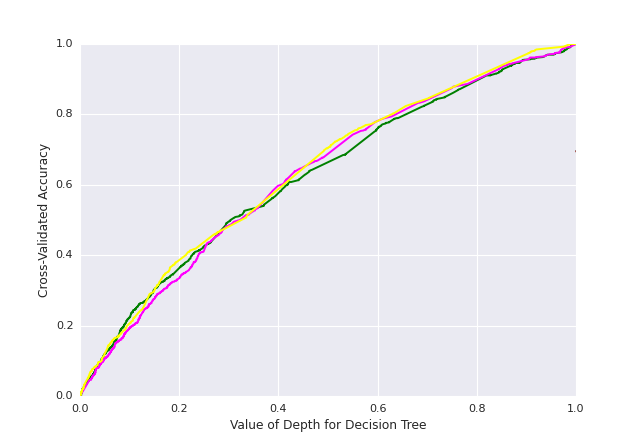

In [34]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg
from sklearn import metrics
import pandas as pd
from ggplot import *


nbm_preds = nbm.predict_proba(X_test)[:,1]
nbm_fpr, nbm_tpr, _ = metrics.roc_curve(y_test, nbm_preds)

nbg_preds = nbg.predict_proba(X_test)[:,1]
nbg_fpr, nbg_tpr, _ = metrics.roc_curve(y_test, nbg_preds)

nbb_preds = nbb.predict_proba(X_test)[:,1]
nbb_fpr, nbb_tpr, _ = metrics.roc_curve(y_test, nbb_preds)

plt.plot(nbm_fpr, nbm_tpr, color='green')
plt.plot(nbg_fpr, nbg_tpr, color='magenta')
plt.plot(nbb_fpr, nbb_tpr, color='yellow')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')


## MODEL3: KNN

In [35]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=9)
strongy = data1.FelRecidYr3
knn.fit(X,y)
scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print scores

[ 0.67305893  0.65668849  0.67539757  0.6499766   0.67150211  0.70425831
  0.67945718  0.68928404  0.65418811  0.63313056]


In [36]:
# use average accuracy as an estimate of out-of-sample accuracy
print scores.mean()

0.668694190688


In [ ]:
# search for an optimal value of K for KNN
k_range = range(1, 100)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    k_scores.append(scores.mean())
print k_scores

In [ ]:
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

### Re-run KNN model with optimized K = 40

In [37]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter)
knn = KNeighborsClassifier(n_neighbors=40)
strongy = data1.FelRecidYr3
knn_scores = cross_val_score(knn, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print knn_scores

[ 0.6950421   0.70813845  0.71094481  0.6888161   0.71736079  0.68366869
  0.71127749  0.70987365  0.69209172  0.68132897]


In [38]:
import math
mean_score = knn_scores.mean()
std_dev = knn_scores.std()
std_error = knn_scores.std() / math.sqrt(scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.699854 +/-  0.008875
95 percent probability that if this experiment were repeated over and over the average score would be between 0.690979 and 0.708729


## MODEL 4: Logistic Regression

In [39]:
# 10-fold cross-validation with logistic regression
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X,y)
logreg_scores = cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print logreg_scores

[ 0.72263798  0.70720299  0.70533209  0.70379036  0.68039307  0.69068788
  0.69489939  0.70940571  0.69630323  0.69957885]


In [40]:
print cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()

0.700884741336


In [41]:
print cross_val_score(logreg, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()

0.658242138262


In [42]:
mean_score = logreg_scores.mean()
std_dev = logreg_scores.std()
std_error = logreg_scores.std() / math.sqrt(logreg_scores.shape[0])
ci =  2.262 * std_error
lower_bound = mean_score - ci
upper_bound = mean_score + ci

print "Score is %f +/-  %f" % (mean_score, ci)
print '95 percent probability that if this experiment were repeated over and over the average score would be between %f and %f' % (lower_bound, upper_bound)

Score is 0.701023 +/-  0.007823
95 percent probability that if this experiment were repeated over and over the average score would be between 0.693200 and 0.708846


## MODEL 5: SVM Polynomial Kernel

In [ ]:

# 10-fold cross-validation with SVM Polynomial
from sklearn import svm
svmpoly = svm.SVC(kernel='poly', gamma=2)
svmpoly.fit(X,y)
svmpoly_scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print svmpoly_scores


In [ ]:
# search for an optimal gamma for SVM Polynomial
g_range = range(1, 10)
g_scores = []
for k in g_range:
    knn = svm.SVC(kernel='poly', gamma=k)
    scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    g_scores.append(scores.mean())
print g_scores

## Tune SVM Hyperparameters - C and gamma

In [ ]:
import optunity
import optunity.metrics
import sklearn.svm

# score function: twice iterated 10-fold cross-validated accuracy
@optunity.cross_validated(x=data1[feature_cols2], y=data1.FelRecidYr3, num_folds=10, num_iter=2)
def svm_auc(x_train, y_train, x_test, y_test, logC, logGamma):
    model = sklearn.svm.SVC(C=10 ** logC, gamma=10 ** logGamma).fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    return optunity.metrics.roc_auc(y_test, decision_values)

# perform tuning
hps, _, _ = optunity.maximize(svm_auc, num_evals=200, logC=[-5, 2], logGamma=[-5, 1])

# train model on the full training set with tuned hyperparameters
optimal_model = sklearn.svm.SVC(C=10 ** hps['logC'], gamma=10 ** hps['logGamma']).fit(data, labels)

## Plotting SVM boundaries

In [ ]:
fignum=1

# plot the line, the points, and the nearest vectors to the plane
    plt.figure(fignum, figsize=(4, 3))
    plt.svmpoly()

    plt.scatter(svmpoly.support_vectors_[:, 0], svmpoly.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10)
    plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired)

    plt.axis('tight')
    x_min = -3
    x_max = 3
    y_min = -3
    y_max = 3

    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = svmpoly.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    plt.pcolormesh(XX, YY, Z > 0, cmap=plt.cm.Paired)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()

## MODEL 5: SVM Gaussian Kernel

In [ ]:

# 10-fold cross-validation with SVM Polynomial
from sklearn import svm
svmpoly = svm.SVC(kernel='poly', gamma=2)
svmpoly.fit(X,y)
svmpoly_scores = cross_val_score(svmpoly, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print svmpoly_scores


# MODEL 6: Decision Tree

In [43]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=15)
clf.fit(X,y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print clf_scores

[ 0.68709074  0.69597755  0.702058    0.67945718  0.67290594  0.69349555
  0.68413664  0.69536734  0.6827328   0.68179691]


In [60]:
clf_scores_mean = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy').mean()
print clf_scores_mean

0.683152816013


In [62]:
clf_scores_auc = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='roc_auc').mean()
print clf_scores_auc

0.598861639405


In [44]:
from sklearn.externals.six import StringIO  
import pydot 
dot_data = StringIO() 
tree.export_graphviz(clf, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue()) 

In [45]:
graph.write_jpeg("hw3_tree_plot.jpg")

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.280316 to fit



True

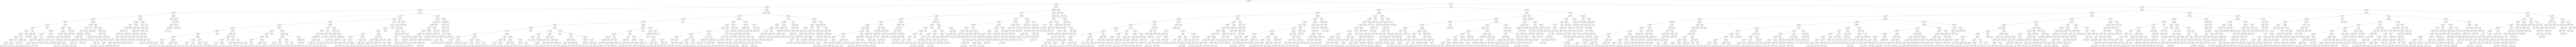

In [46]:
from IPython.display import Image
Image(filename='hw3_tree_plot.jpg')

In [54]:
# search for an optimal gamma for Decision Tree
t_range = range(1, 100)
t_scores = []
for k in t_range:
    clf = tree.DecisionTreeClassifier(max_depth=k)
    scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
    t_scores.append(scores.mean())
print t_scores

[0.69522231361293041, 0.69690820953637478, 0.69934095820750086, 0.69929396665197308, 0.69863812037279827, 0.69868438965476642, 0.69760837714761481, 0.69424030610391196, 0.69512900900127961, 0.6945693126538387, 0.69129292657804731, 0.69269636976554128, 0.69213444093618914, 0.69091911718034904, 0.68885952129459438, 0.68736222631851041, 0.68712687457347565, 0.68886002469737839, 0.68507047420104505, 0.68783043468173788, 0.68712831912059469, 0.68759703088660618, 0.68731547552083583, 0.68647312945374683, 0.68652016478342959, 0.68497535296195644, 0.68455527428229002, 0.68530304628722938, 0.68717552954689798, 0.68609923250773819, 0.68441475924433548, 0.68703634962067495, 0.6879709278326146, 0.68464960758658644, 0.68656720011311245, 0.68680027560208068, 0.68614642104696388, 0.68572544499711763, 0.68488312081710578, 0.68703483941232324, 0.68506808850959067, 0.68357331054742654, 0.68535132918033326, 0.68450847971046025, 0.68488329591372632, 0.68829901512528369, 0.68347965574253444, 0.686614169781

<IPython.core.display.Javascript object>


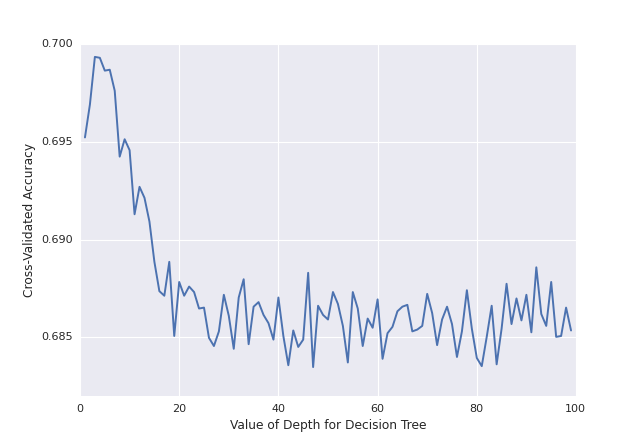

In [55]:
import matplotlib
%matplotlib nbagg

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(t_range, t_scores)
plt.xlabel('Value of Depth for Decision Tree')
plt.ylabel('Cross-Validated Accuracy')

### Re-run Decision Tree model with optimized Depth = 50

In [ ]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(max_depth=50)
clf.fit(X,y)
clf_scores = cross_val_score(clf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')
print clf_scores

# MODEL 7: Bootstrap Aggregation using Decision Tree

## Summary information for all models - DATA2 - RECIDIVISM

In [14]:
# TASK 7: plot the ROC curve
import matplotlib
%matplotlib nbagg
from sklearn import metrics
import pandas as pd
from ggplot import *

knn_preds = knn.predict_proba(X_test)[:,1]
knn_fpr, knn_tpr, _ = metrics.roc_curve(y_test, knn_preds)

nbm_preds = nbm.predict_proba(X_test)[:,1]
nbm_fpr, nbm_tpr, _ = metrics.roc_curve(y_test, nbm_preds)

nbg_preds = nbg.predict_proba(X_test)[:,1]
nbg_fpr, nbg_tpr, _ = metrics.roc_curve(y_test, nbg_preds)

nbb_preds = nbb.predict_proba(X_test)[:,1]
nbb_fpr, nbb_tpr, _ = metrics.roc_curve(y_test, nbb_preds)

logreg_preds = logreg.predict_proba(X_test)[:,1]
logreg_fpr, logreg_tpr, _ = metrics.roc_curve(y_test, logreg_preds)

clf_preds = clf.predict_proba(X_test)[:,1]
clf_fpr, clf_tpr, _ = metrics.roc_curve(y_test, clf_preds)

plt.plot(knn_fpr, knn_tpr, color='blue')
plt.plot(logreg_fpr, logreg_tpr, color='red')
plt.plot(nbm_fpr, nbm_tpr, color='green')
plt.plot(nbg_fpr, nbg_tpr, color='magenta')
plt.plot(nbg_fpr, nbg_tpr, color='yellow')
plt.plot(clf_fpr, clf_tpr, color='orange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')




NameError: name 'knn' is not defined

## MODEL 8: Random Forest

In [ ]:
X

In [101]:
# Let's build our first model. I always have oob_score=True. It is a good idea to increase n_estimators to a number higher than 
# the default. In this case the oob_predictions will be based on a forest of 33 trees. I set random_state=42 so that you all can
# replicate the model exactly.
rf = RandomForestRegressor(n_estimators=100, oob_score=True, random_state=42)

# I only use numeric_variables because I have yet to dummy out the categorical variables
rf.fit(X, y)
rf_scores = cross_val_score(rf, X, y, cv=KFold(X.shape[0], n_folds=10, shuffle=True), scoring='accuracy')

ValueError: Can't handle mix of binary and continuous

In [ ]:
print rf_scores

In [85]:
rf.oob_score_

0.0023630521703090768

In [88]:
y_oob = rf.oob_prediction_
print "c-stat: ", roc_auc_score(y, y_oob)

c-stat:  0.629906687286


In [97]:
# descriptive stats on variables
def describe_categorical(X):
    """
    Just like .describe(), but returns the results for
    categorical variables only.
    """
    from IPython.display import display, HTML
    display(HTML(X[X.columns[X.dtypes == "int64"]].describe().to_html()))

In [98]:
describe_categorical(X)

,AgeAsses3RN,AgeAtFirstConvR,JvFelCon,JvVioCon,JvComit,HomConv,SexConv,VProCon,AssaCon,DomVio,CopFodNd3,CopBugNd3,CopTraNd3,CopHygNd3,CopMedNd3,CopMHNd3
count,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.000000,21373.00000,21373.000000,21373.000000,21373.000000
mean,3.128480,0.840453,0.233472,0.059889,0.029149,0.007954,0.162682,0.088102,0.204651,0.171057,0.123988,0.117953,0.15164,0.024189,0.074814,0.092874
std,1.177992,0.899132,0.719016,0.266276,0.199292,0.088832,0.443376,0.310999,0.472174,0.428961,0.329576,0.322559,0.35868,0.153640,0.263097,0.290263
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,3.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,6.000000,3.000000,5.000000,3.000000,2.000000,1.000000,2.000000,2.000000,3.000000,2.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


## Re-Run MODEL 8: Random Forest - after Feature Exraction

In [99]:
model = RandomForestRegressor(100, oob_score=True, n_jobs=-1, random_state=42)
model.fit(X, y)
print "C-stat: ", roc_auc_score(y, model.oob_prediction_)

C-stat:  0.629906687286
